# Detección de Idiomas - LSTM

### Importar librerías

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Cargar el dataset

In [4]:
df = pd.read_csv("dataset/updated_language_detection.csv")
df.describe()

,Text,Language
count,21821,21821
unique,21821,22
top,aprilie sonda spațială messenger a nasa și-a ...,Japanese
freq,1,1000


### Preprocesar el Texto

- Tokenización: Convertir el texto en tokens (palabras).
- Padding: Asegurarse de que todas las secuencias de texto tengan la misma longitud.

In [5]:
# Unir todos los textos en una lista
texts = df['Text'].values

# Inicializar el Tokenizer para convertir texto en índices
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)

# Convertir los textos a secuencias de índices
X = tokenizer.texts_to_sequences(texts)

# Padding para asegurar que todas las secuencias tengan la misma longitud
X = pad_sequences(X, maxlen=100)
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  304,  254, 1270,   61,  304, 9223,
        313,  204, 5609,   61, 7433, 2140,   86, 3595, 7433, 2140,   86,
       3595], dtype=int32)

### Codificar las Etiquetas

Codificamos las etiquetas (idiomas) en valores numéricos.

In [9]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Language'])
y[:5]

array([ 4, 17, 19, 18,  2])

### Dividir el dataset en conjuntos de entrenamiento y prueba

Se utiliza stratify para mantener la proporción de clases en los conjuntos de entrenamiento y prueba.

Train: 70%

Validation: 10%

Test: 20%

In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Language'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
print("Prueba:", X_test.shape, y_test.shape)

Entrenamiento: (15274, 100) (15274,)
Validación: (2182, 100) (2182,)
Prueba: (4365, 100) (4365,)


### Construcción del Modelo LSTM

Aquí creamos la arquitectura del modelo con una capa de Embedding, seguida de una capa LSTM y capas densas para la clasificación.

In [16]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compilar el Modelo

Ahora compilamos el modelo usando una función de pérdida adecuada (entropía cruzada) y un optimizador (Adam).

In [17]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

### Entrenar el Modelo

In [18]:
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 70s 267ms/step - accuracy: 0.3742 - loss: 2.0647 - val_accuracy: 0.9166 - val_loss: 0.2363
Epoch 2/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 66s 276ms/step - accuracy: 0.9188 - loss: 0.2292 - val_accuracy: 0.9262 - val_loss: 0.1826
Epoch 3/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 64s 268ms/step - accuracy: 0.9338 - loss: 0.1492 - val_accuracy: 0.9216 - val_loss: 0.1739
Epoch 4/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 63s 262ms/step - accuracy: 0.9388 - loss: 0.1314 - val_accuracy: 0.9258 - val_loss: 0.1613
Epoch 5/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 65s 273ms/step - accuracy: 0.9412 - loss: 0.1249 - val_accuracy: 0.9326 - val_loss: 0.1713


### Evaluación del Modelo

In [19]:
score, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy: {accuracy * 100:.2f}%')

137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9214 - loss: 0.1725
Accuracy: 92.60%


### Ejemplos de Predicciones

In [34]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
language_names = label_encoder.classes_
decoded_texts = tokenizer.sequences_to_texts(X_test)

for i in range(5):
    predicted_language = language_names[y_pred[i]]
    real_language = language_names[y_test[i]]

    print(f"Texto: {decoded_texts[i]}")
    print(f"Predicción: {predicted_language} (Real: {real_language})\n")

137/137 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step
Texto: په c کى ساتل شى پنسلينونه دهغه انتى څخه کيږي چه په تاثير کوي او چه لپاره ډير وړ ده ځکه چه خوا څخه فشار په مقابل کي حفاظت کوي او خوا څخه ئي شکل وړ ده چه پنسلين په ګرام منفى تاثير او همدارنګه په مقابل کى ئي منفى يو شان العمل نه ښايي کله چه انتى دعضلى او يا هم تطبيق شى نو وروسته په وينه کى اعظمى دغه پنسلينونه په مقابل کى مقاومت نلري خو بيا هم په کى دخولى استعماليږي بايد دوز څخه پنځه زيات استعمال شى څخه وروسته په توگه ئي شروع کيږي پنسلين ټولو
Predicción: Pushto (Real: Pushto)

Texto: اسلام میکسیکو میں میکسیکو زبان میں buku google
Predicción: Urdu (Real: Urdu)

Texto: diğer merkez türkiye merkez bankası avrupa merkez bankası merkez bankası birçok özel birçok ülkenin olup ya da diğer olup da ve etmek gibi farklı olan vardır
Predicción: Turkish (Real: Turkish)

Texto: le octobre le de la ligne de à de est la de de avec le novembre de la ligne de à de le er janvier la de un de à
Predicción: French (Real: French)

Texto: हालांकि वेरॉन के के बाद 

#### Matriz de Confusión

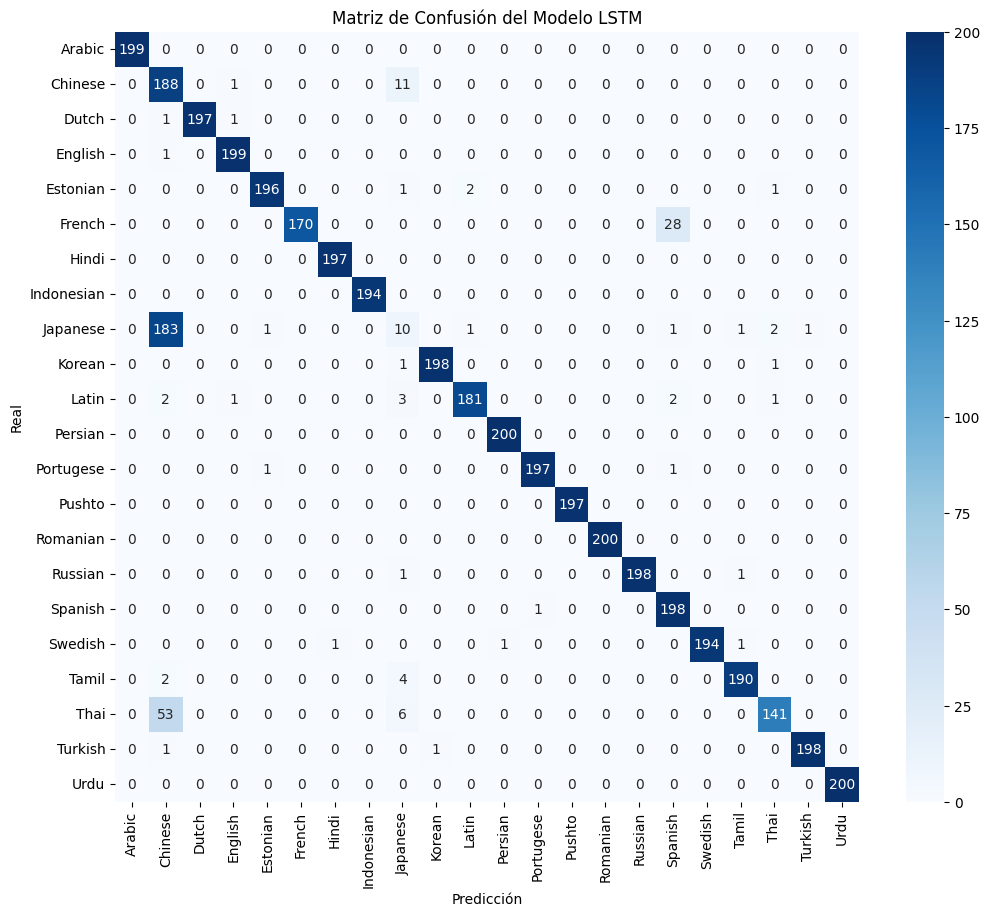

<Figure size 640x480 with 0 Axes>

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión del Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
plt.savefig("plots/lstm_confusion_matrix.png")